In [1]:
%%capture
!pip install transformers

import torch 
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator, LabelField
from torchtext import datasets

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import copy

sns.set(palette='summer')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
len(tokenizer)

30522

In [4]:
# const values
BATCH_SIZE = 32
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
SOFTMAX_TEMP = 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device: ', device)

Current device:  cuda:0


In [5]:
# Fields
label_field = LabelField(batch_first=True)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

In [6]:
%%time
train, test = datasets.IMDB.splits(text_field, label_field)  # Takes about 3 minutes

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:12<00:00, 7.01MB/s]


CPU times: user 3min 8s, sys: 10 s, total: 3min 18s
Wall time: 3min 30s


In [7]:
label_field.build_vocab(train)

In [11]:
valid, test = test.split(0.5)

In [12]:
train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)

In [13]:
valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

# Модель 

In [14]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text):
        """
        return: (loss, logits)
        """
        res = self.encoder(text, return_dict=True)

        #return loss, text_fea
        return res['logits']

### Utils

In [47]:
def save_checkpoint(save_path, model):    
    torch.save(model.state_dict(), save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(torch.load(load_path, map_location=device))


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def calculate_classification_metrics(pred, real):
    tp = (pred[real == 1] == 1).sum()
    fp = (pred[real == 0] == 1).sum()
    fn = (pred[real == 1] == 0).sum()

    accuracy = (pred == real).sum() / real.shape[0]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

def soft_cross_entropy(predicted, target):
    return -(target * torch.log(predicted)).sum(dim=1).mean()

def evaluate(eval_iter, model, temperature=SOFTMAX_TEMP, criterion=nn.NLLLoss(), show=False):
    model.eval()

    predicted = torch.LongTensor([0])
    real = torch.LongTensor([0])
    valid_running_loss = []

    with torch.no_grad():
        for batch in eval_iter:
            text = batch.text.to(device)
            labels = batch.label.to(device)
            logits = model(text)
            
            softmax_targets = nn.LogSoftmax(dim=1)(logits / temperature)
            
            valid_running_loss.append(criterion(
                softmax_targets,
                labels
                ).item())

            predicted = torch.cat(
                [predicted, softmax_targets.argmax(dim=1).to('cpu')]
                )
            real = torch.cat([real, labels.to('cpu')])
    metrics = calculate_classification_metrics(predicted.numpy(), real.numpy())

    if show:
        print("Accuracy {} \nPrecision {}\nRecall {}\nF1 {}".format(*metrics))
        
    return np.array(valid_running_loss).mean(), metrics

### Train session 

In [16]:
from tqdm import tqdm_notebook
from tqdm import notebook
destination_folder = '/content/drive/My Drive/bert'

In [54]:
def train(model,
          optimizer,
          criterion=nn.NLLLoss(),
          train_loader=train_iter,
          valid_loader=valid_iter,
          num_epochs=2,
          eval_every=len(train_iter) // 2,
          file_path=destination_folder,
          temperature=1, 
          best_valid_loss=float("Inf"),
          name='unknown.pt',
          metrics_name='unknown_metrics.pt',
          distillation=False,
          distill_model=None,
          show=False
          ):
    assert not (distillation and distill_model is None), 'Try to distillate without distillation model :('

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    metrics = []  # tuple of classification metrics

    # training loop
    model.train()
    for epoch in range(num_epochs):
        print('Current epoch: {}'.format(epoch))
        for batch in notebook.tqdm(train_loader):
            text = batch.text.to(device)
            labels = batch.label.to(device)
            logits = model(text)

            if distillation:
                softmax_targets = nn.Softmax(dim=1)(logits / temperature)
                with torch.no_grad():
                    soft_labels = nn.Softmax(dim=1)(distill_model(text) / temperature)
                loss = soft_cross_entropy(softmax_targets, soft_labels.detach())
            else:
                softmax_targets = nn.LogSoftmax(dim=1)(logits / temperature)
                loss = criterion(softmax_targets, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            global_step += 1

            torch.cuda.empty_cache()

            if global_step % eval_every == 0:
                valid_running_loss, current_metrics = evaluate(valid_loader, model, show=show)

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                metrics.append(current_metrics)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + name, model)
                    save_metrics(file_path + '/' + metrics_name, train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + metrics_name, train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [16]:
torch.cuda.empty_cache()

In [17]:
!nvidia-smi

Thu Sep 24 17:28:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [96]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [109]:
train(model=model, optimizer=optimizer, temperature=SOFTMAX_TEMP, show=true)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch [1/2], Step [260/1564], Train Loss: 0.3049, Valid Loss: 0.3275
Accuracy 0.8563429851223804 
Precision 0.8972457627118644
Recall 0.8071791613722998
F1 0.8498327759197324
Model saved to ==> /content/drive/My Drive/bert/bert.pt
Model saved to ==> /content/drive/My Drive/bert/metrics.pt
Epoch [1/2], Step [520/1564], Train Loss: 0.3057, Valid Loss: 0.2926
Accuracy 0.877459606462966 
Precision 0.8851875808538163
Recall 0.8694409148665819
F1 0.8772435897435897
Model saved to ==> /content/drive/My Drive/bert/bert.pt
Model saved to ==> /content/drive/My Drive/bert/metrics.pt
Epoch [1/2], Step [780/1564], Train Loss: 0.3990, Valid Loss: 0.3214
Accuracy 0.8614621660534314 
Precision 0.9095477386934674
Recall 0.8049555273189326
F1 0.8540613414223122



Epoch [2/2], Step [1040/1564], Train Loss: 0.1675, Valid Loss: 0.2957
Accuracy 0.8787394016957287 
Precision 0.8649969456322542
Recall 0.8996188055908514
F1 0.8819682341949548
Epoch [2/2], Step [1300/1564], Train Loss: 0.1866, Valid Loss: 0.3044
Accuracy 0.8745800671892497 
Precision 0.8394600804135555
Recall 0.9285260482846251
F1 0.8817496229260935
Epoch [2/2], Step [1560/1564], Train Loss: 0.2701, Valid Loss: 0.3234
Accuracy 0.8710606302991521 
Precision 0.8846911957950065
Recall 0.8554637865311309
F1 0.8698320413436693

Model saved to ==> /content/drive/My Drive/bert/metrics.pt
Finished Training!


Model loaded from <== /content/drive/My Drive/bert/metrics.pt


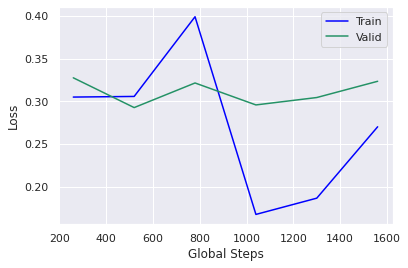

In [111]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train', color='Blue')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [18]:
bert_model = BERT().to(device)

load_checkpoint(destination_folder + '/bert.pt', bert_model)
ret = evaluate(test_iter, bert_model, show=True)


Model loaded from <== /content/drive/My Drive/bert/bert.pt
Accuracy 0.8782594784834427 
Precision 0.8834732085216268
Recall 0.8724896397832324
F1 0.8779470729751404


## Actual experiments

Try different size and architectures of NN: 

RNN with hidden sizes: 128, 256, 512


CNN with hidden size: ...

### Neural nets

In [22]:
class CNN(nn.Module):
    def __init__(self, hidden_dim, emb_dim, vocab_size, kernel_sizes, dropout=0.5):
        super().__init__()

        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.convolutions = nn.ModuleList()
        self.lin1 = nn.Linear(hidden_dim * len(kernel_sizes), hidden_dim * len(kernel_sizes))
        self.lin2 = nn.Linear(hidden_dim * len(kernel_sizes), 2)
        self.dropout = nn.Dropout(dropout)
        self.nonlin = nn.LeakyReLU(0.2)

        for k_size in kernel_sizes:
          self.convolutions.append(
              nn.Sequential(
                  nn.Conv1d(emb_dim, hidden_dim, kernel_size=k_size, padding=k_size // 2),
                  nn.LeakyReLU(0.2)
                  )
              )
    
    def forward(self, x): # [batch_size, seq_len]
        x = self.embed(x) # [batch_size, seq_len, D]
        x = x.permute((0, 2, 1)) # [batch_size, D, seq_len]

        res = []

        for layer in self.convolutions:
            current = torch.max(layer(x), dim=2).values
            res.append(current)
        
        x = self.nonlin(self.lin1(torch.cat(res, dim=1)))
        logit = self.lin2(self.dropout(x))
        return logit

In [23]:
class RNN(nn.Module):
    def __init__(self, hidden_dim, emb_dim, vocab_size, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim) 
        self.GRU = nn.GRU(emb_dim, hidden_dim, num_layers=1, batch_first=True) 
        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(dropout)
        self.nonlin = nn.LeakyReLU(0.2)

        self.logprob = nn.LogSoftmax(dim=1)
            
    def forward(self, seq):
        inputs = self.embedding(seq)
        output, hidden = self.GRU(inputs)
        hidden = self.nonlin(self.lin1(self.nonlin(hidden.squeeze(0))))
        hidden = self.lin2(self.dropout(hidden))

        return hidden

### Solid train

Тренировка моделей с нуля, для сравнения с Knowledge distillation

In [24]:
HIDDEN_DIMS = [64, 128, 256]

In [25]:
def chunk_train(
    models=[], 
    hidden_dims=HIDDEN_DIMS, 
    save_name='unk', 
    epoch_num=3, 
    model_type='unk', 
    distill_model=None
    ):

    assert len(models) == len(hidden_dims)

    model_metrics = {}
    for current_model, current_hidden_dim in zip(models, HIDDEN_DIMS):
        print('Running experiment for {} with {} hidden units'.format(model_type, current_hidden_dim))

        if distill_model is None:
            train(
                model=current_model, 
                optimizer=optim.Adam(current_model.parameters(), lr=1e-3), 
                temperature=SOFTMAX_TEMP, 
                name=save_name + '_{}.pt'.format(current_hidden_dim), 
                metrics_name=save_name + '{}_metrics.pt'.format(current_hidden_dim),
                num_epochs=epoch_num,
                show=False
                )
        else:
            train(
                model=current_model, 
                optimizer=optim.Adam(current_model.parameters(), lr=1e-3), 
                temperature=SOFTMAX_TEMP, 
                name=save_name + '_{}.pt'.format(current_hidden_dim), 
                metrics_name=save_name + '{}_metrics.pt'.format(current_hidden_dim),
                num_epochs=epoch_num,
                distillation=True,
                distill_model=distill_model,
                show=False
                )
        _, model_metrics[current_hidden_dim] = evaluate(test_iter, current_model, show=True)
        print('=' * 100)

    return model_metrics

### Создадим по две копии моделей, чтобы инициализированные веса совпадали для обучения с нуля и Knowledge Distillation

In [57]:
rnn_models = []
cnn_models = []
kernel_sizes = [3,4,5]

for i in range(len(HIDDEN_DIMS)):
    rnn_models.append(
        RNN(
            hidden_dim=HIDDEN_DIMS[i],
            emb_dim=128, 
            vocab_size=len(tokenizer)).to(device)
            )

    cnn_models.append(
        CNN(
            hidden_dim=HIDDEN_DIMS[i],
            emb_dim=128, 
            vocab_size=len(tokenizer), 
            kernel_sizes=kernel_sizes).to(device)
            )

rnn_models_distill = copy.deepcopy(rnn_models)
cnn_models_distill = copy.deepcopy(cnn_models)

In [58]:
chunk_train(
    models=rnn_models, 
    hidden_dims=HIDDEN_DIMS, 
    save_name='rnn', 
    epoch_num=2, 
    model_type='rnn'
    )

Running experiment for rnn with 64 hidden units
Current epoch: 0


Epoch [1/2], Step [391/1564], Train Loss: 0.6909, Valid Loss: 0.6917
Model saved to ==> /content/drive/My Drive/bert/rnn_64.pt
Model saved to ==> /content/drive/My Drive/bert/rnn64_metrics.pt
Epoch [1/2], Step [782/1564], Train Loss: 0.6853, Valid Loss: 0.6882
Model saved to ==> /content/drive/My Drive/bert/rnn_64.pt
Model saved to ==> /content/drive/My Drive/bert/rnn64_metrics.pt

Current epoch: 1


Epoch [2/2], Step [1173/1564], Train Loss: 0.6715, Valid Loss: 0.6745
Model saved to ==> /content/drive/My Drive/bert/rnn_64.pt
Model saved to ==> /content/drive/My Drive/bert/rnn64_metrics.pt
Epoch [2/2], Step [1564/1564], Train Loss: 0.6222, Valid Loss: 0.6166
Model saved to ==> /content/drive/My Drive/bert/rnn_64.pt
Model saved to ==> /content/drive/My Drive/bert/rnn64_metrics.pt

Model saved to ==> /content/drive/My Drive/bert/rnn64_metrics.pt
Finished Training!
Accuracy 0.677011678131499 
Precision 0.6319641170915958
Recall 0.8533630857507173
F1 0.7261630272616303
Running experiment for rnn with 128 hidden units
Current epoch: 0


KeyboardInterrupt: ignored

In [ ]:
chunk_train(
    models=cnn_models, 
    hidden_dims=HIDDEN_DIMS, 
    save_name='cnn', 
    epoch_num=3, 
    model_type='cnn'
    )

### Knowledge distillation

In [55]:
chunk_train(
    models=rnn_models_distill, 
    hidden_dims=HIDDEN_DIMS, 
    save_name='rnn_distill', 
    epoch_num=2, 
    model_type='rnn',
    distill_model=bert_model
    )

Running experiment for cnn with 64 hidden units
Current epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:735: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Epoch [1/2], Step [391/1564], Train Loss: 0.6932, Valid Loss: 0.6910
Model saved to ==> /content/drive/My Drive/bert/rnn_distill_64.pt
Model saved to ==> /content/drive/My Drive/bert/rnn_distill64_metrics.pt
Epoch [1/2], Step [782/1564], Train Loss: 0.6834, Valid Loss: 0.6738
Model saved to ==> /content/drive/My Drive/bert/rnn_distill_64.pt
Model saved to ==> /content/drive/My Drive/bert/rnn_distill64_metrics.pt

Current epoch: 1


Epoch [2/2], Step [1173/1564], Train Loss: 0.6549, Valid Loss: 0.6230
Model saved to ==> /content/drive/My Drive/bert/rnn_distill_64.pt
Model saved to ==> /content/drive/My Drive/bert/rnn_distill64_metrics.pt
Epoch [2/2], Step [1564/1564], Train Loss: 0.6039, Valid Loss: 0.5831
Model saved to ==> /content/drive/My Drive/bert/rnn_distill_64.pt
Model saved to ==> /content/drive/My Drive/bert/rnn_distill64_metrics.pt

Model saved to ==> /content/drive/My Drive/bert/rnn_distill64_metrics.pt
Finished Training!
Accuracy 0.7267637178051511 
Precision 0.718568369531967
Recall 0.7488045903729678
F1 0.7333749609740867
Running experiment for cnn with 128 hidden units
Current epoch: 0


KeyboardInterrupt: ignored

In [ ]:
chunk_train(
    models=cnn_models_distill, 
    hidden_dims=HIDDEN_DIMS, 
    save_name='cnn_distill', 
    epoch_num=2, 
    model_type='cnn',
    distill_model=bert_model
    )